In [108]:
import numpy as np
import os
from imageio import imread
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
import csv

In [109]:
## Checking the GPU configuration
!nvidia-smi

import tensorflow as tf

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

Mon Mar 18 18:44:54 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8     3W /  N/A |   2830MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [110]:
data_path = './dataset_aug'
csv_path = './dataset_aug.csv'

data = []
with open(csv_path, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        data.append(row)

data = np.array(data)

num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=34)

gesture_num = 6
np.random.seed(34)

In [111]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [112]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [113]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, gesture_num)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        vid = t[folder + (batch*batch_size)]
        vid_path = os.path.join(source_path, os.path.join(vid[1], vid[0]))
        imgs = os.listdir(vid_path) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
#             print("idx: ", idx)
#             print("item: ",item)
            image = imread(os.path.join(vid_path, imgs[item])).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = normalizeImage(image[:, :, 0])
            batch_data[folder,idx,:,:,1] = normalizeImage(image[:, :, 1])
            batch_data[folder,idx,:,:,2] = normalizeImage(image[:, :, 2])

#         print("folder: ", folder)
#         print("index:  ", int(t[folder + (batch*batch_size)].strip().split(',')[2]))
        batch_labels[folder, int(vid[2])] = 1
    return batch_data, batch_labels

In [114]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [115]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 90, 160, 3]

In [123]:
def plotModelHistory(fold_results):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))

    total_val_loss = 0
    total_val_acc = 0

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for i, fold_result in enumerate(fold_results):
        total_val_loss += fold_results[i]['val_loss']
        total_val_acc += fold_results[i]['val_accuracy']

        h = fold_result['history']
        train_loss.append(h.history['loss'])
        val_loss.append(h.history['val_loss'])
        train_acc.append(h.history['categorical_accuracy'])
        val_acc.append(h.history['val_categorical_accuracy'])

    avg_train_loss = np.mean(train_loss, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    std_train_loss = np.std(train_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)

    ax[0].plot(range(1, len(avg_train_loss) + 1), avg_train_loss)   
    ax[0].plot(range(1, len(avg_val_loss) + 1), avg_val_loss)
    ax[0].fill_between(range(1, len(avg_train_loss) + 1), 
                       (avg_train_loss - std_train_loss), 
                       (avg_train_loss + std_train_loss), 
                       alpha=0.2, color='blue')
    ax[0].fill_between(range(1, len(avg_val_loss) + 1), 
                       (avg_val_loss - std_val_loss), 
                       (avg_val_loss + std_val_loss), 
                       alpha=0.2, color='orange')
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    avg_train_acc = np.mean(train_acc, axis=0)
    avg_val_acc = np.mean(val_acc, axis=0)
    std_train_acc = np.std(train_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    ax[1].plot(range(1, len(avg_train_acc) + 1), avg_train_acc)   
    ax[1].plot(range(1, len(avg_val_acc) + 1), avg_val_acc)
    ax[1].fill_between(range(1, len(avg_train_acc) + 1), 
                       (avg_train_acc - std_train_acc), 
                       (avg_train_acc + std_train_acc), 
                       alpha=0.2, color='blue')
    ax[1].fill_between(range(1, len(avg_val_acc) + 1), 
                       (avg_val_acc - std_val_acc), 
                       (avg_val_acc + std_val_acc), 
                       alpha=0.2, color='orange')
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    
    plt.show()
    print(f"Mean Validation Loss: {total_val_loss / len(fold_results)}")
    print(f"Mean Validation Accuracy: {total_val_acc / len(fold_results)}")

In [117]:
n_frames = 15
num_epochs = 30
batch_size = 8

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [LR]

fold_results1 = []

for fold, (train_index, val_index) in enumerate(skf.split(data, data[:, 2])):
    print("fold: ", fold)
    train_doc, val_doc = data[train_index], data[val_index]    

    img_tensor = getImgTensor(n_frames)
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model1 = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(gesture_num, activation='softmax')
    ], name="conv_3d1")
    model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    # print(model1.summary())
    
    train_generator = generator(data_path, train_doc, batch_size, img_tensor)
    val_generator = generator(data_path, val_doc, batch_size, img_tensor)

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    validation_results = model1.evaluate_generator(val_generator, steps=validation_steps)
    print("Validation Loss:", validation_results[0])
    print("Validation Accuracy:", validation_results[1])

    fold_results1.append({
        'history': model1_history,
        'val_loss': validation_results[0],
        'val_accuracy': validation_results[1]
    })

fold:  0
# training sequences = 960
# validation sequences = 240
Source path =  ./dataset_aug ; batch size = 8
Epoch 1/30
120/120 [==============================] - 47s 384ms/step - loss: 2.0987 - categorical_accuracy: 0.2583 - val_loss: 1.9227 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 44s 366ms/step - loss: 1.7507 - categorical_accuracy: 0.3448 - val_loss: 1.7824 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 45s 372ms/step - loss: 1.7119 - categorical_accuracy: 0.3479 - val_loss: 2.1442 - val_categorical_accuracy: 0.3083 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 45s 379ms/step - loss: 1.5476 - categorical_accuracy: 0.4083 - val_loss: 1.3592 - val_categorical_accuracy: 0.4750 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 54s 454ms/step - loss: 1.3828 - categorical_accuracy: 0.4615 - val_loss: 1.7457 - val_categorical_accuracy:

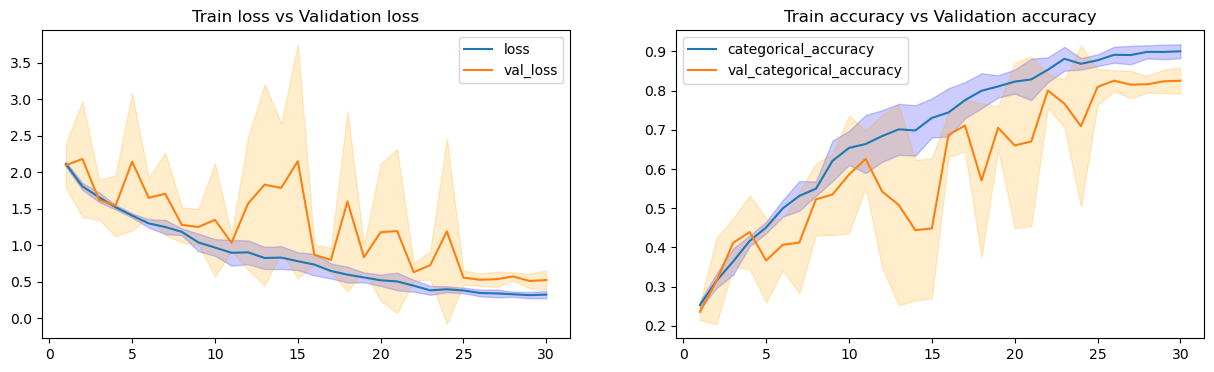

Mean Validation Loss: 0.5225926220417023
Mean Validation Accuracy: 0.8233333349227905


In [118]:
plotModelHistory(fold_results1)

In [119]:
n_frames = 30
num_epochs = 30
batch_size = 8

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [LR]

fold_results2 = []

for fold, (train_index, val_index) in enumerate(skf.split(data, data[:, 2])):
    print("fold: ", fold)
    train_doc, val_doc = data[train_index], data[val_index]

    img_tensor = getImgTensor(n_frames)
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
    
    model2 = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(gesture_num, activation='softmax')
    ], name="conv_3d2")
    model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    # print(model2.summary())
    
    train_generator = generator(data_path, train_doc, batch_size, img_tensor)
    val_generator = generator(data_path, val_doc, batch_size, img_tensor)

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model1_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    validation_results = model2.evaluate_generator(val_generator, steps=validation_steps)
    print("Validation Loss:", validation_results[0])
    print("Validation Accuracy:", validation_results[1])

    fold_results2.append({
        'history': model1_history,
        'val_loss': validation_results[0],
        'val_accuracy': validation_results[1]
    })

fold:  0
# training sequences = 960
# validation sequences = 240
Source path =  ./dataset_aug ; batch size = 8
Epoch 1/30
120/120 [==============================] - 96s 794ms/step - loss: 2.0491 - categorical_accuracy: 0.2625 - val_loss: 2.3525 - val_categorical_accuracy: 0.2458 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 92s 769ms/step - loss: 1.8061 - categorical_accuracy: 0.3094 - val_loss: 2.1020 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 96s 801ms/step - loss: 1.6376 - categorical_accuracy: 0.3604 - val_loss: 2.1387 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 93s 776ms/step - loss: 1.4993 - categorical_accuracy: 0.4292 - val_loss: 1.2513 - val_categorical_accuracy: 0.5042 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 92s 769ms/step - loss: 1.4547 - categorical_accuracy: 0.4479 - val_loss: 1.2651 - val_categorical_accuracy:

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/conv_3d2/max_pooling3d_45/MaxPool3D/MaxPool3DGrad' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\envs\ml\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\envs\ml\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\envs\ml\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\envs\ml\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\envs\ml\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Rebecca Sun\AppData\Local\Temp\ipykernel_2532\458664231.py", line 62, in <module>
      model1_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/conv_3d2/max_pooling3d_45/MaxPool3D/MaxPool3DGrad'
OOM when allocating tensor with shape[8,16,13,43,78] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/conv_3d2/max_pooling3d_45/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_324048]

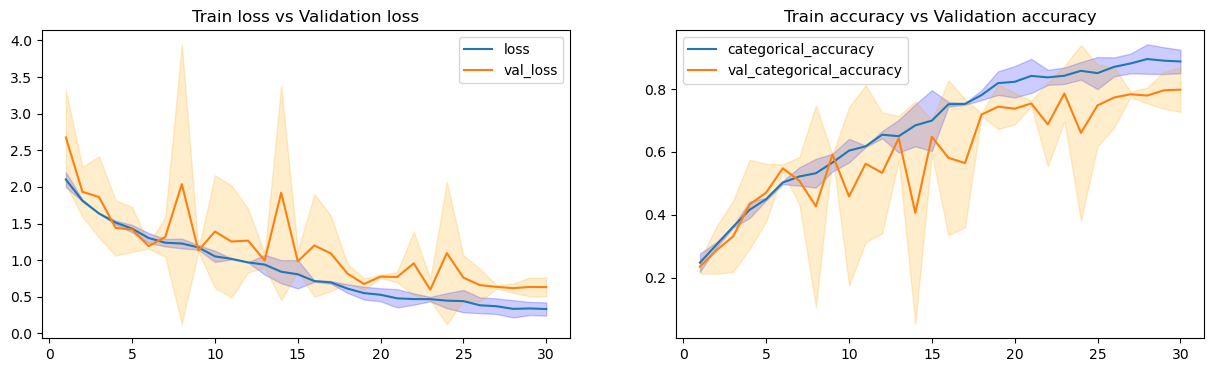

Mean Validation Loss: 0.6379182934761047
Mean Validation Accuracy: 0.7958333194255829


In [124]:
plotModelHistory(fold_results2)